# RNA-Seq classification

In [1]:
import pandas as pd
from sklearn.svm import SVC
import sklearn

import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

In [2]:
def plot_conf(SPLIT_NAME, conf):

    fig, ax = plt.subplots()
        
    lab = ["Negative", "Positive"]

    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in conf.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in conf.flatten()/np.sum(conf)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sn.heatmap(conf, annot=labels, fmt='', cmap='Blues', ax= ax)

    ax.set_xticklabels(lab)
    ax.set_yticklabels(lab)

    ax.set_xlabel("Predicted class")
    ax.set_ylabel("True class")

    
    fig.savefig(f"C:/Users/Alejandro/Desktop/heterogeneous-data/results/RNASeq/conf/conf_matrix_{SPLIT_NAME}.pdf")

In [3]:
def preprocess(train_data, test_data):
    train_sample_ids, test_sample_ids = train_data["Unnamed: 0"], test_data["Unnamed: 0"]
    train_genes, test_genes = train_data.columns[1:-1], test_data.columns[1:-1]

    genes = list(set(train_genes).intersection(test_genes))

    for column in test_data:
        if column not in genes:
            test_data.drop(column, axis="columns")

    for column in train_data:
        if column not in genes:
            train_data.drop(column, axis="columns")

    train_X, test_X = [list(row[1][genes]) for row in train_data.iterrows()], [list(row[1][genes]) for row in test_data.iterrows()]
    train_y, test_y = [0 if dat=="Solid Tissue Normal" else 1 for dat in train_data["Labels"]], [0 if dat=="Solid Tissue Normal" else 1 for dat in test_data["Labels"]]

    #test_X, test:y = sklearn.utils.shuffle(test_X, test_y, random_state=0)
    
    return train_X, train_y, test_X, test_y, train_sample_ids, test_sample_ids

In [11]:
SPLITS = [0,1,2,3,4,5,6,7,8,9]
tot_conf, tot_acc, tot_f1 = [], [], []


for SPLIT in SPLITS:

    train_out = pd.DataFrame(columns=["Sample ID", "Output", "Label"])
    test_out = pd.DataFrame(columns=["Sample ID", "Output", "Label"])
    
    train_data = pd.read_csv(f"D:/data/RNASeq/dataset/mRMR-LC-2classes-RNA-train{SPLIT}.csv")
    test_data = pd.read_csv(f"D:/data/RNASeq/dataset/mRMR-LC-2classes-RNA-test{SPLIT}.csv")

    train_X, train_y, test_X, test_y, train_sample_ids, test_sample_ids = preprocess(train_data, test_data)

    clf = SVC(probability=True, kernel="rbf")

    clf.fit(train_X, train_y)

    train_out["Sample ID"], test_out["Sample ID"] = train_sample_ids, test_sample_ids
    train_out["Output"], test_out["Output"] = clf.predict_proba(train_X)[:,0], clf.predict_proba(test_X)[:,0]
    train_out["Label"], test_out["Label"] = train_y, test_y

    out_test = clf.predict(test_X)
    labels = test_y

    conf_m = sklearn.metrics.confusion_matrix(labels, out_test, labels=[0, 1])
    acc = sklearn.metrics.accuracy_score(labels, out_test)
    f1 = sklearn.metrics.f1_score(labels, out_test)

    print(f"SPLIT{SPLIT}\n{conf_m}\n{acc}")

    tot_conf.append(conf_m)
    tot_acc.append(acc)
    tot_f1.append(f1)

    train_out.to_csv(f"D:\data\Outputs\RNASeq\PDAC_train_{SPLIT}.csv")
    test_out.to_csv(f"D:\data\Outputs\RNASeq\PDAC_test_{SPLIT}.csv")

SPLIT0
[[ 7  2]
 [ 1 17]]
0.8888888888888888
SPLIT1
[[ 7  0]
 [ 0 20]]
1.0
SPLIT2
[[ 5  1]
 [ 0 16]]
0.9545454545454546
SPLIT3
[[ 4  0]
 [ 2 18]]
0.9166666666666666
SPLIT4
[[ 5  0]
 [ 2 15]]
0.9090909090909091
SPLIT5
[[ 4  2]
 [ 0 18]]
0.9166666666666666
SPLIT6
[[ 2  0]
 [ 0 14]]
1.0
SPLIT7
[[ 2  0]
 [ 0 17]]
1.0
SPLIT8
[[ 6  0]
 [ 0 17]]
1.0
SPLIT9
[[ 9  3]
 [ 1 21]]
0.8823529411764706


Accuracy: 0.947 0.047
F1-Score:  0.963 0.033
[[ 51   8]
 [  6 173]]


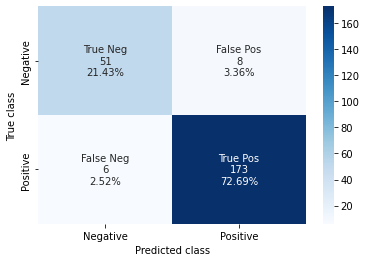

In [12]:
print("Accuracy:", round(np.mean(tot_acc), 3), round(np.std(tot_acc),3))
print("F1-Score: ", round(np.mean(tot_f1), 3), round(np.std(tot_f1), 3))
tot_conf = np.sum(tot_conf, axis=0)
print(tot_conf)

plot_conf("10CV", tot_conf)